In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import pymatching
import json


In [13]:
def q_func(d,t,r,c,i):
    # qubit indices as defined in the paper
    return int(((d-1)/2+r*(i+1)+1)*(t*d+(1-t)) -1 + 2*c*(d*(1-t)-t))
def a_func(d,t,r,c,i):
# ancilla indices as defined in the paper
    return int((d**2-1)/4*(1+2*t) + ((r-1)/2+r*i)*(d+1)/2 +c )

def idx_to_coord(d):
    """
    This is to keep track of index assignment to data and ancilla qubits
    c.f. Figure 9 of arXiv:2202.05741
    """
    q_list = {}
    sz_list = {}
    c_sz = (d**2-1)-1
    for row in range(d):
        for col in range(d):
            x, y = col-(d-1)/2, row-(d-1)/2
            q_list[f"{d**2-d+col-d*row}"] = (x,y)
            if row %2 ==1 and col % 2 == 0:
                x_sz, y_sz = x+0.5, y+ 0.5
                sz_list[f"{c_sz}"] = (x_sz, y_sz)
                c_sz -= 1
            if row %2 ==0 and col % 2 == 0 and row < d-1:
                x_sz, y_sz = x-0.5, y+ 0.5
                sz_list[f"{c_sz}"] = (x_sz, y_sz)
                c_sz -= 1

    c_q = 0
    sx_list = {}
    c_sx = 0# (d**2-1)-1
    for col in range(d):
        for row in range(d):
            x, y = col-(d-1)/2, (d-1)/2-row
            if row %2 ==0 and col % 2 == 1:
                x_s, y_s = x+0.5, y- 0.5
                sx_list[f"{c_sx}"] = (x_s, y_s)
                c_sx += 1
            if row %2 ==0 and col % 2 == 0 and col < d-1:
                x_s, y_s = x+0.5, y+ 0.5
                sx_list[f"{c_sx}"] = (x_s, y_s)
                c_sx += 1
    return q_list, sx_list, sz_list

def code_initialization(d):
    """
        Calculate necessary mappings from qubit indices to qubit location,
        stabilizer matrix
        logical operator matrix
        input:
            d :int  surface code distance
        output:
            s_mat : X, Z stabilizer matrix
            logicals : X, Z logical operator matrix
    """
    c_list = np.arange((d+1)//2) # c as defined in the paper
    x_stab_to_c = np.zeros((d**2-1)//2,dtype=int)
    t = 0
    for r in [-1,1]:
        for c in c_list:
            for i in range((d-1)//2 ):
                x_stab_to_c[a_func(d,t,r,c,i)] = c

    z_stab_to_c = np.zeros((d**2-1)//2,dtype=int)
    t = 1
    for r in [-1,1]:
        for c in c_list:
            for i in range((d-1)//2 ):
                z_stab_to_c[a_func(d,t,r,c,i)-(d**2-1)//2] = c

    q_list, sx_list, sz_list = idx_to_coord(d)

    # define stabilizers 
    s_mat = np.zeros(((d**2-1), 2*d**2))
    for sx in sx_list:
        r_sx = sx_list[sx]
        for q in q_list:
            r_q = q_list[q]
            if (r_q[0]-r_sx[0])**2+(r_q[1]-r_sx[1])**2 < 1:
                # print(sx,q)
                s_mat[int(sx),int(q)] = 1

    for sz in sz_list:
        r_sz = sz_list[sz]
        for q in q_list:
            r_q = q_list[q]
            if (r_q[0]-r_sz[0])**2+(r_q[1]-r_sz[1])**2 < 1:
                # print(sx,q)
                s_mat[int(sz),d**2+ int(q)] = 1

    # define logical operators
    logicals = np.zeros((2,2*d**2))
    logicals[0,np.arange(0,d**2,d)]= 1 # x logical
    logicals[1,d**2+np.arange(d**2-d, d**2)]= 1 # z logical

    stab_matrices = (x_stab_to_c,z_stab_to_c,sx_list,sz_list)
    return stab_matrices, s_mat, logicals





In [14]:

Niter = 10000 # you may want to increase the number of iterations to reduce error 
d_list = [3,5,7] # you can change this list for different vlaues of distances
p_err_list = np.arange(0.02,0.21,0.05) # you can increase the number of points 
logical_err = np.zeros((p_err_list.shape[0],len(d_list)))
for i_d, d in enumerate(d_list):
    print(f"code dist: {d}")
    tic = time.time()
    data_list = {}
    JSON_PATH = f"results/mwpm_sweep_d_{d}.json"
    data_list["p_err"] = p_err_list.tolist()
    stab_matrices, s_mat, logicals = code_initialization(d)
    #x_stab_to_c,z_stab_to_c,sx_list,sz_list = stab_matrices
    p_err = 0.15
    weights = np.ones(d**2) * np.log((1-p_err)/p_err)
    ind = (d**2-1)//2
    matching_x = pymatching.Matching(s_mat[:ind,:d**2],spacelike_weights=weights)
    matching_z = pymatching.Matching(s_mat[ind:,d**2:],spacelike_weights=weights)
    pauli = [0,1,2,3] # I X Z Y
    for i_p, p_err in enumerate(p_err_list):
        for iter in range(Niter):
            err_instance = np.array(random.choices(pauli, [1-p_err,p_err/3,p_err/3,p_err/3], k=d**2))
            x_err = np.argwhere(err_instance==1)[:,0]
            z_err = np.argwhere(err_instance==2)[:,0]
            y_err = np.argwhere(err_instance==3)[:,0]
            # print(z_err)
            # print(err_instance)
            err_vec = np.zeros(2*d**2)
            if len(x_err)> 0:
                err_vec[x_err] = 1
            if len(z_err)> 0:
                err_vec[d**2 + np.array(z_err)] = 1
            if len(y_err)> 0:
                err_vec[y_err] = 1
                err_vec[d**2 + np.array(y_err)] = 1

            comm_mat = np.kron([[0,1],[1,0]],np.eye(d**2))
            syndrome = (s_mat@ (comm_mat @err_vec)) % 2
            active_syndrome_idx = np.argwhere(syndrome>0)[:,0]

            syndrome_x = syndrome[:ind]
            syndrome_z = syndrome[ind:]

            recovery_x = matching_x.decode(syndrome_x)
            recovery_z = matching_z.decode(syndrome_z)

            idx_recovery_z = np.argwhere(recovery_z>0)[:,0]
            idx_recovery_x = np.argwhere(recovery_x>0)[:,0]

            err_rec = np.copy(err_vec)
            err_rec[idx_recovery_z] += 1
            err_rec[d**2 + idx_recovery_x] += 1
            err_rec %= 2
            logical_err[i_p,i_d] += np.sum(logicals@ (comm_mat @ err_rec) % 2)>0
#             print("i_d %s i_p %s / %s iteration %s / %s "%(i_d,i_p,len(p_err_list),iter,Niter),end="\r")
        # we store the logical error rate for this physical error rate (physical error probability index i_p)
        logical_err[i_p,i_d] /= Niter
    data_list["logical_err"] = logical_err[:,i_d].tolist()
    
    
    # we store the x-axis and y-axis for each distance (d value) in a JSON format
    with open(JSON_PATH, 'w') as json_file:
        json_file.write(json.dumps(data_list) + '\n')
    toc = time.time()
    print(f"Finished in {toc-tic} sec.")


code dist: 3
Finished in 16.036213159561157 sec.
code dist: 5
Finished in 17.75599718093872 sec.
code dist: 7
Finished in 20.905534267425537 sec.


# a simple code to plot logical error rate as physical error rate


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


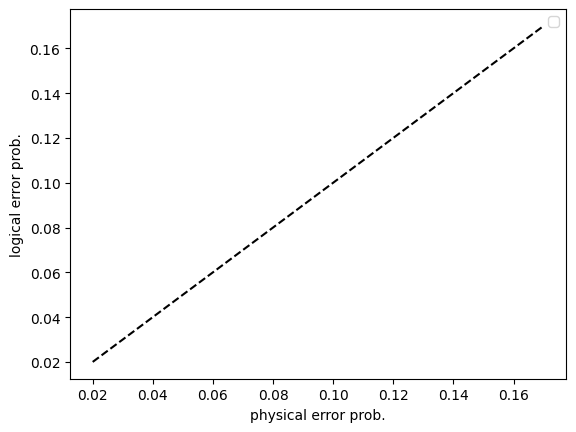

In [15]:
#You need to pars the results from the file and plot it

plt.plot(p_err_list,p_err_list,"k--")
plt.xlabel("physical error prob.")
plt.ylabel("logical error prob.")
plt.legend()
plt.show()